# VES Experiments for 2D Bayesian Optimization

In [26]:
from ves import *
import matplotlib.pyplot as plt
import numpy as np
import torch

Maximizer is  tensor([1., 1.])


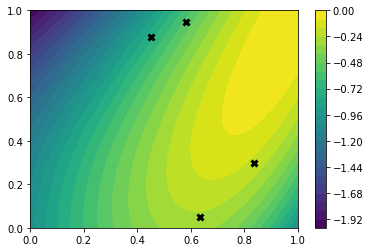

In [27]:
train_X = torch.rand(4, 2, dtype=torch.double)
def f(X):
    if isinstance(X, tuple):
        x,y = X
    elif X.ndim != 2:
        x,y = X[0],X[1]
    else:
        x,y = X[:,0],X[:,1]
    return (-1 * (y - x**2)**2 - (1 - x)**2)
train_Y = f(train_X).reshape(-1,1)
bounds = torch.zeros(2,2)
bounds[:, 1] = torch.ones(2)

# plot function f
nx,ny = 101,101 # grid size for x and y
X1,X2 = torch.linspace(bounds[0,0],bounds[0,1],nx),torch.linspace(bounds[1,0],bounds[1,1],ny)
Xx,Xy = torch.meshgrid(X1,X2)
X = torch.vstack((Xx.flatten(),Xy.flatten())).T
Y = f(X)

plt.contourf(Xx, Xy, f((Xx,Xy)),25)
plt.colorbar()
plt.plot(train_X[:,0], train_X[:,1], 'kx', mew=3)
print('Maximizer is ',X[torch.argmax(Y)])

In [28]:
f((Xx,Xy)).flatten()

tensor([-1.0000e+00, -1.0001e+00, -1.0004e+00,  ..., -4.0000e-04,
        -1.0000e-04, -0.0000e+00])

In [30]:
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.sampling.pathwise import draw_matheron_paths
NUM_PATHS = 1000
outcome_transform = Standardize(m=1)
gp = SingleTaskGP(train_X, train_Y, outcome_transform=outcome_transform) # gp model
mll = ExactMarginalLogLikelihood(gp.likelihood, gp) # mll object
_ = fit_gpytorch_mll(mll) # fit mll hyperpara
best_f = train_Y.max()
paths = draw_matheron_paths(gp, torch.Size([NUM_PATHS]))
model = VariationalEntropySearch(gp, bounds=bounds, best_f=best_f, paths=paths)


In [31]:
kvals, betavals, ei, val = model(X, return_ves=True)

Maximizer of EI is  tensor(0.8500) tensor(0.2400)
Maximizer of VES is  tensor(0.6100) tensor(0.9100)


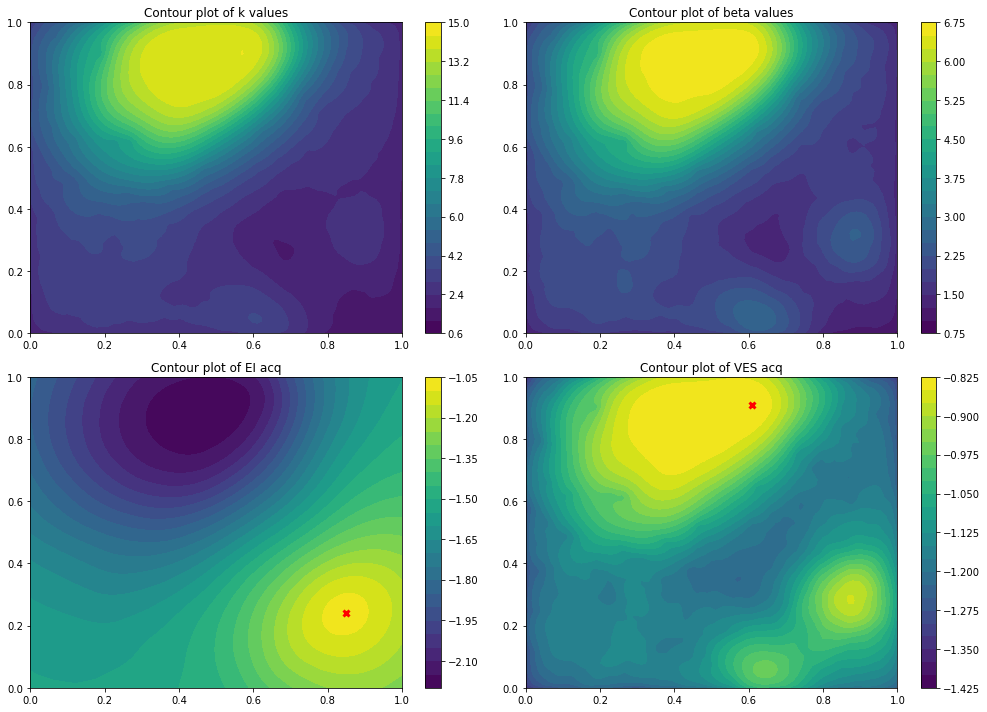

In [32]:
einp = ei.reshape(nx,ny).detach().numpy()
eix, eiy = np.unravel_index(np.argmax(einp, axis=None), einp.shape)
print('Maximizer of EI is ',Xx[eix,eiy],Xy[eix,eiy])
valnp = val.reshape(nx,ny).detach().numpy()
valx, valy = np.unravel_index(np.argmax(valnp, axis=None), valnp.shape)
print('Maximizer of VES is ',Xx[valx,valy],Xy[valx,valy])

fig, axs = plt.subplots(2, 2, figsize=(14, 10))  # Create a 2x2 grid of subplots

# Contour plots
cs1 = axs[0, 0].contourf(Xx, Xy, kvals.reshape(nx,ny).detach().numpy(), 25)
cs2 = axs[0, 1].contourf(Xx, Xy, betavals.reshape(nx,ny).detach().numpy(), 25)
cs3 = axs[1, 0].contourf(Xx, Xy, ei.reshape(nx,ny).detach().numpy(), 25)
axs[1, 0].plot(Xx[eix,eiy], Xy[eix,eiy], 'kx', mew=3, c='r')
cs4 = axs[1, 1].contourf(Xx, Xy, val.reshape(nx,ny).detach().numpy(), 25)
axs[1, 1].plot(Xx[valx,valy], Xy[valx,valy], 'kx', mew=3, c='r')

# Adding colorbars and titles for each subplot
fig.colorbar(cs1, ax=axs[0, 0])
axs[0, 0].set_title('Contour plot of k values')

fig.colorbar(cs2, ax=axs[0, 1])
axs[0, 1].set_title('Contour plot of beta values')

fig.colorbar(cs3, ax=axs[1, 0])
axs[1, 0].set_title('Contour plot of EI acq')

fig.colorbar(cs4, ax=axs[1, 1])
axs[1, 1].set_title('Contour plot of VES acq')

plt.tight_layout()  # Adjust the layout
plt.show()